In [13]:
import torch
from bertviz import head_view
from transformers import MT5TokenizerFast, MT5ForConditionalGeneration
from datasets import load_dataset
import matplotlib.pyplot as plt
import numpy as np

from overfit_attention import prepare_text_input


In [3]:
# Some features are shared among all models
shortest_article_ids = [260, 1301, 2088, 665, 1572, 436, 1887, 1422, 1506, 474]

dataset = load_dataset("dennlinger/klexikon")
tokenizer = MT5TokenizerFast.from_pretrained("google/mt5-small")

for idx in shortest_article_ids:
    # Load index-specific model
    model = MT5ForConditionalGeneration.from_pretrained(f"./overfit_models/{idx}")
    
    sample = dataset["train"][idx]
    # Prepare with sensible border tokens. Decoder needs to start with <pad>
    wiki_text = f"<extra_id_0> {prepare_text_input(sample['wiki_sentences'], max_sentences=15)}"
    klexikon_text = f"<pad> {prepare_text_input(sample['klexikon_sentences'], max_sentences=5)}"

    # Prepare forward pass
    model_inputs = tokenizer(wiki_text, return_tensors="pt")
    decoder_inputs = tokenizer(klexikon_text, return_tensors="pt")
    model_inputs["decoder_input_ids"] = decoder_inputs["input_ids"]
    
    result = model(input_ids=model_inputs["input_ids"], attention_mask=model_inputs["attention_mask"],
                   decoder_input_ids=model_inputs["decoder_input_ids"], output_attentions=True,
                   labels=model_inputs["decoder_input_ids"])
    
    # Check predicted tokens for sanity check
    predicted_ids = torch.argmax(result.logits.detach().to("cpu"), dim=-1)
    print(tokenizer.decode(predicted_ids[0]))
    
    break


Using custom data configuration dennlinger--klexikon-713c6b3fddad5d3f
Reusing dataset json (/home/dennis/.cache/huggingface/datasets/json/dennlinger--klexikon-713c6b3fddad5d3f/0.0.0/c90812beea906fcffe0d5e3bb9eba909a80a998b5f88e9f8acbd320aa91acfde)


  0%|          | 0/3 [00:00<?, ?it/s]

<pad></s>Eine Blume ist der farbige Teil einer Pflanze. <extra_id_1> Eine Blume ist eigentlich eine Blüte. <extra_id_1> In der Blüte bilden sich die Samen. <extra_id_1> Die meisten Blumen brauchen Insekten, welche die Bestäubung übernehmen. <extra_id_1> So können sich dann Samen bilden.</s>


In [9]:
result.cross_attentions[0].shape

torch.Size([1, 6, 73, 468])

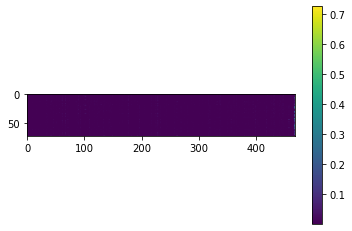

In [16]:
plt.imshow(result.cross_attentions[0][0,0,:,:].detach().numpy())
plt.colorbar()
plt.show()